# Titanic - Machine Learning Challenge Core

## Descripción del Proyecto

Este notebook implementa un análisis completo del dataset de Titanic para predecir la supervivencia de los pasajeros. El proyecto incluye:

1. **Exploración y Análisis de Datos (EDA)**
2. **Preprocesamiento de Datos**
3. **Implementación y Evaluación de 5 Modelos de ML**
4. **Benchmark y Comparación de Rendimiento**
5. **Generación de Predicciones**

## Modelos Implementados
- Regresión Logística
- K-Nearest Neighbors (KNN)
- Árbol de Decisión
- XGBoost
- LightGBM

---

**Autor:** Challenge Técnico ML  
**Dataset:** Titanic - Machine Learning from Disaster (Kaggle)  
**Objetivo:** Predecir supervivencia con accuracy > 80%


In [2]:
# Importación de librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Configuración de visualización
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

# Librerías de Machine Learning
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve

# Modelos de Machine Learning
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import lightgbm as lgb

print("✅ Todas las librerías importadas correctamente")
print(f"Versión de pandas: {pd.__version__}")
print(f"Versión de numpy: {np.__version__}")
print(f"Versión de XGBoost: {xgb.__version__}")
print(f"Versión de LightGBM: {lgb.__version__}")


✅ Todas las librerías importadas correctamente
Versión de pandas: 2.2.3
Versión de numpy: 2.2.1
Versión de XGBoost: 3.0.2
Versión de LightGBM: 4.6.0


## 1. Carga y Exploración Inicial de Datos

En esta sección cargaremos los datasets y realizaremos una exploración inicial para entender la estructura y características de los datos.


In [3]:
# Carga de datos
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
submission_sample = pd.read_csv('gender_submission.csv')

print("📊 Datasets cargados correctamente")
print(f"🚂 Datos de entrenamiento: {train_df.shape}")
print(f"🧪 Datos de prueba: {test_df.shape}")
print(f"📝 Muestra de submission: {submission_sample.shape}")

# Primera visualización de los datos
print("\n" + "="*50)
print("PRIMERAS 5 FILAS DEL DATASET DE ENTRENAMIENTO")
print("="*50)
display(train_df.head())

print("\n" + "="*50)
print("INFORMACIÓN GENERAL DEL DATASET")
print("="*50)
print(train_df.info())


📊 Datasets cargados correctamente
🚂 Datos de entrenamiento: (891, 12)
🧪 Datos de prueba: (418, 11)
📝 Muestra de submission: (418, 2)

PRIMERAS 5 FILAS DEL DATASET DE ENTRENAMIENTO


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S



INFORMACIÓN GENERAL DEL DATASET
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None


In [4]:
# Estadísticas descriptivas
print("="*60)
print("ESTADÍSTICAS DESCRIPTIVAS - VARIABLES NUMÉRICAS")
print("="*60)
display(train_df.describe())

print("\n" + "="*60)
print("ESTADÍSTICAS DESCRIPTIVAS - VARIABLES CATEGÓRICAS")
print("="*60)
display(train_df.describe(include=['O']))

# Análisis de valores faltantes
print("\n" + "="*60)
print("ANÁLISIS DE VALORES FALTANTES")
print("="*60)

missing_train = train_df.isnull().sum()
missing_test = test_df.isnull().sum()

missing_df = pd.DataFrame({
    'Train_Missing': missing_train,
    'Train_Percentage': (missing_train / len(train_df)) * 100,
    'Test_Missing': missing_test,
    'Test_Percentage': (missing_test / len(test_df)) * 100
})

missing_df = missing_df[missing_df['Train_Missing'] > 0].sort_values('Train_Missing', ascending=False)
display(missing_df)

# Distribución de la variable objetivo
print("\n" + "="*60)
print("DISTRIBUCIÓN DE LA VARIABLE OBJETIVO (SURVIVED)")
print("="*60)
survival_counts = train_df['Survived'].value_counts()
survival_percentage = train_df['Survived'].value_counts(normalize=True) * 100

print(f"No sobrevivieron (0): {survival_counts[0]} pasajeros ({survival_percentage[0]:.1f}%)")
print(f"Sobrevivieron (1): {survival_counts[1]} pasajeros ({survival_percentage[1]:.1f}%)")
print(f"Tasa de supervivencia: {survival_percentage[1]:.1f}%")


ESTADÍSTICAS DESCRIPTIVAS - VARIABLES NUMÉRICAS


,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200



ESTADÍSTICAS DESCRIPTIVAS - VARIABLES CATEGÓRICAS


,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Dooley, Mr. Patrick",male,347082,G6,S
freq,1,577,7,4,644



ANÁLISIS DE VALORES FALTANTES


,Train_Missing,Train_Percentage,Test_Missing,Test_Percentage
Cabin,687,77.104377,327.0,78.229665
Age,177,19.865320,86.0,20.574163
Embarked,2,0.224467,0.0,0.000000



DISTRIBUCIÓN DE LA VARIABLE OBJETIVO (SURVIVED)
No sobrevivieron (0): 549 pasajeros (61.6%)
Sobrevivieron (1): 342 pasajeros (38.4%)
Tasa de supervivencia: 38.4%


## 2. Análisis Exploratorio de Datos (EDA)

En esta sección realizaremos visualizaciones para entender mejor las relaciones entre variables y identificar patrones que nos ayuden en la construcción de nuestros modelos.


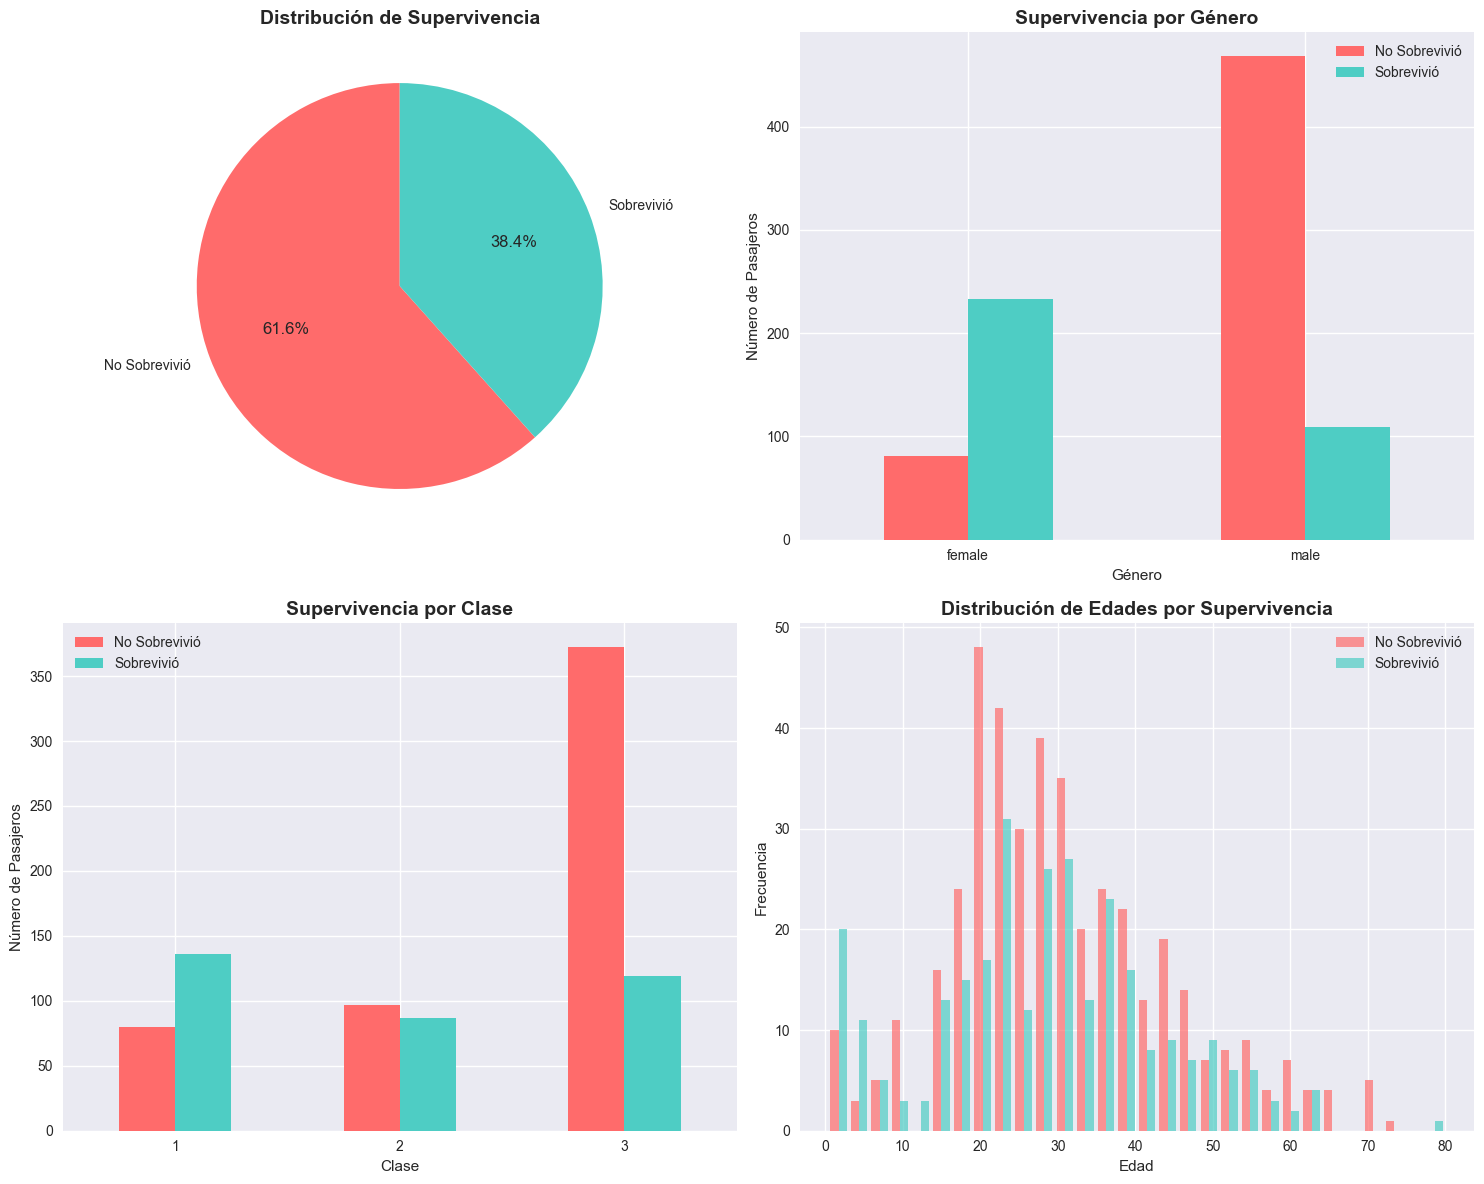

In [5]:
# Visualización de la distribución de supervivencia
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Distribución general de supervivencia
axes[0,0].pie(survival_counts.values, labels=['No Sobrevivió', 'Sobrevivió'], 
              autopct='%1.1f%%', startangle=90, colors=['#ff6b6b', '#4ecdc4'])
axes[0,0].set_title('Distribución de Supervivencia', fontsize=14, fontweight='bold')

# 2. Supervivencia por género
survival_sex = pd.crosstab(train_df['Sex'], train_df['Survived'])
survival_sex.plot(kind='bar', ax=axes[0,1], color=['#ff6b6b', '#4ecdc4'])
axes[0,1].set_title('Supervivencia por Género', fontsize=14, fontweight='bold')
axes[0,1].set_xlabel('Género')
axes[0,1].set_ylabel('Número de Pasajeros')
axes[0,1].legend(['No Sobrevivió', 'Sobrevivió'])
axes[0,1].tick_params(axis='x', rotation=0)

# 3. Supervivencia por clase
survival_class = pd.crosstab(train_df['Pclass'], train_df['Survived'])
survival_class.plot(kind='bar', ax=axes[1,0], color=['#ff6b6b', '#4ecdc4'])
axes[1,0].set_title('Supervivencia por Clase', fontsize=14, fontweight='bold')
axes[1,0].set_xlabel('Clase')
axes[1,0].set_ylabel('Número de Pasajeros')
axes[1,0].legend(['No Sobrevivió', 'Sobrevivió'])
axes[1,0].tick_params(axis='x', rotation=0)

# 4. Distribución de edades
axes[1,1].hist([train_df[train_df['Survived']==0]['Age'].dropna(), 
                train_df[train_df['Survived']==1]['Age'].dropna()], 
               bins=30, alpha=0.7, label=['No Sobrevivió', 'Sobrevivió'],
               color=['#ff6b6b', '#4ecdc4'])
axes[1,1].set_title('Distribución de Edades por Supervivencia', fontsize=14, fontweight='bold')
axes[1,1].set_xlabel('Edad')
axes[1,1].set_ylabel('Frecuencia')
axes[1,1].legend()

plt.tight_layout()
plt.show()


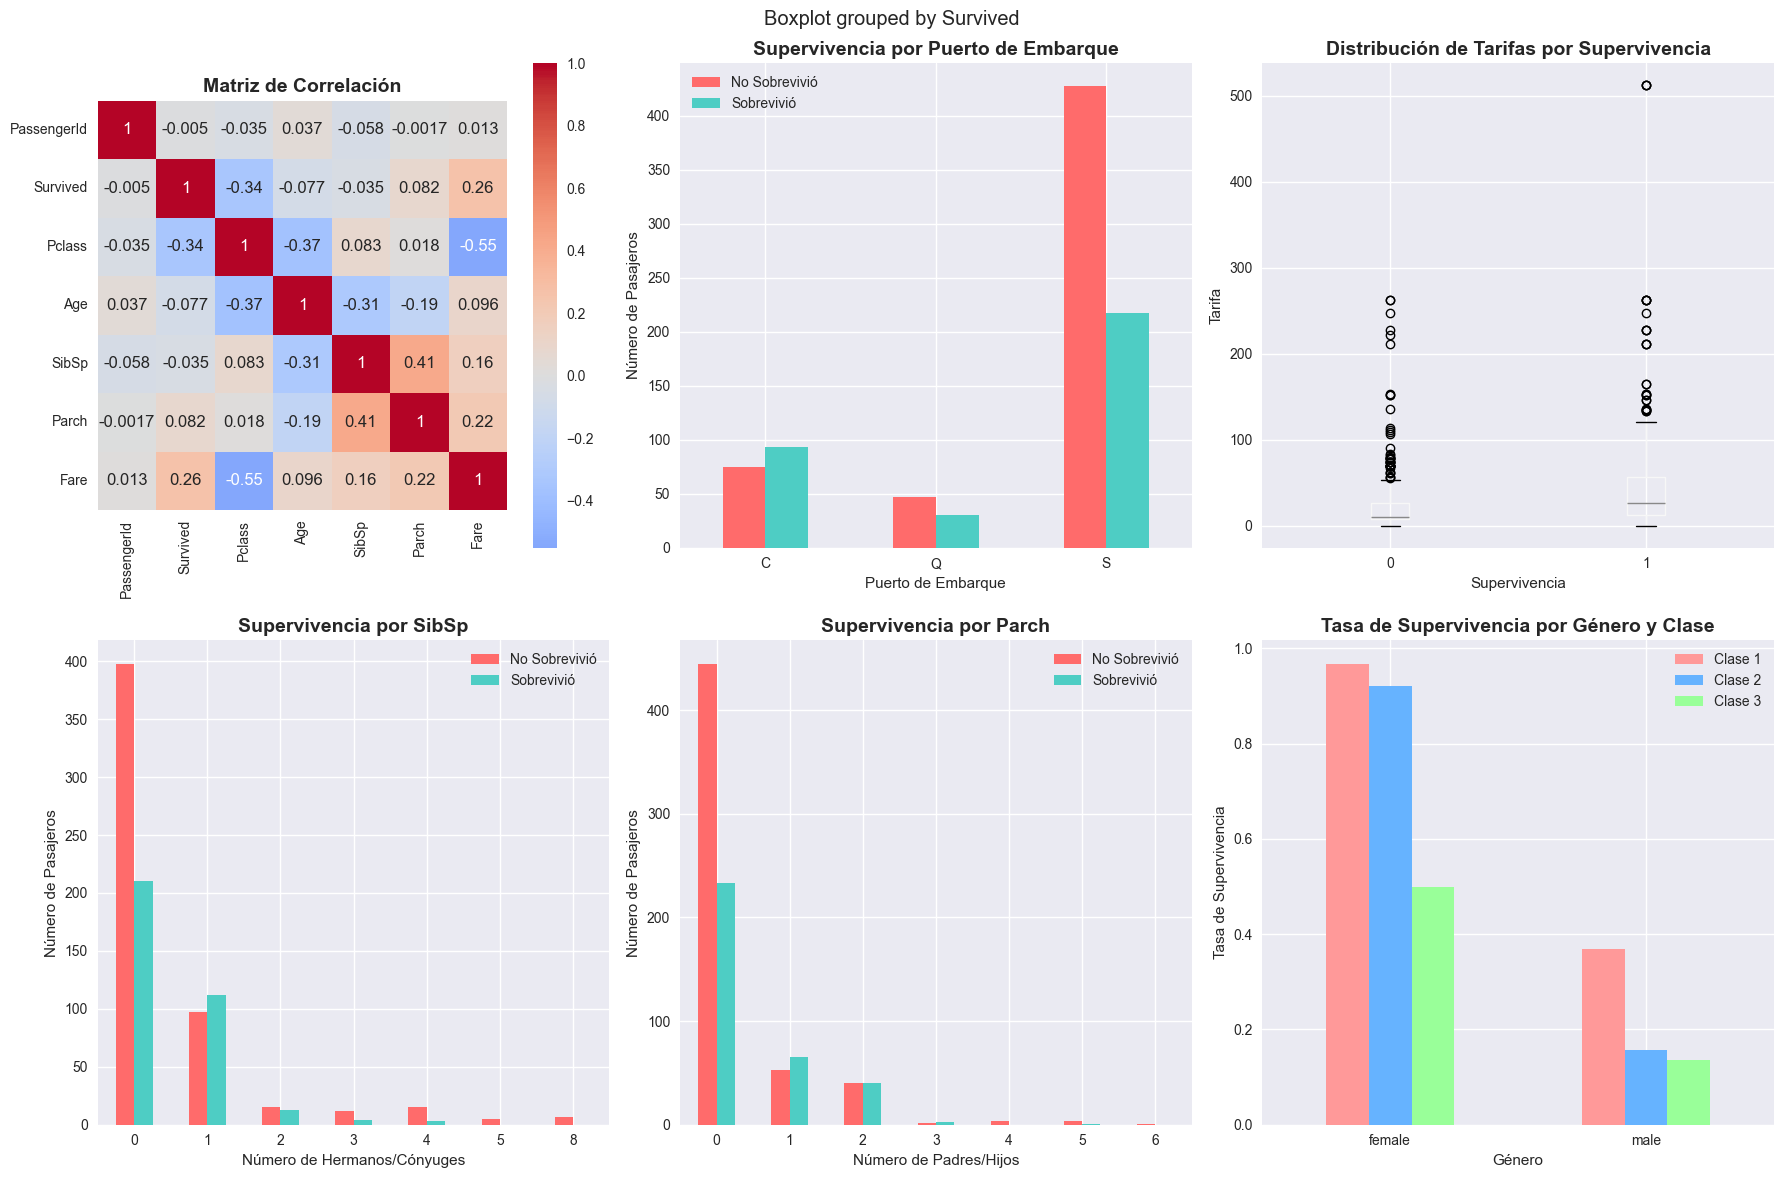


🔍 INSIGHTS PRINCIPALES DEL ANÁLISIS EXPLORATORIO
1. Las mujeres tuvieron una tasa de supervivencia significativamente mayor que los hombres
2. Los pasajeros de primera clase tuvieron mayor probabilidad de supervivencia
3. Los niños (edades menores) tuvieron mejores tasas de supervivencia
4. Los pasajeros que pagaron tarifas más altas tendieron a sobrevivir más
5. El puerto de embarque muestra algunas diferencias en supervivencia
6. Tener muchos hermanos/cónyuges o padres/hijos puede haber afectado la supervivencia


In [6]:
# Análisis más detallado de correlaciones y patrones
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 1. Mapa de calor de correlaciones
numeric_cols = train_df.select_dtypes(include=[np.number]).columns
correlation_matrix = train_df[numeric_cols].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, ax=axes[0,0])
axes[0,0].set_title('Matriz de Correlación', fontsize=14, fontweight='bold')

# 2. Supervivencia por puerto de embarque
survival_embarked = pd.crosstab(train_df['Embarked'], train_df['Survived'])
survival_embarked.plot(kind='bar', ax=axes[0,1], color=['#ff6b6b', '#4ecdc4'])
axes[0,1].set_title('Supervivencia por Puerto de Embarque', fontsize=14, fontweight='bold')
axes[0,1].set_xlabel('Puerto de Embarque')
axes[0,1].set_ylabel('Número de Pasajeros')
axes[0,1].legend(['No Sobrevivió', 'Sobrevivió'])
axes[0,1].tick_params(axis='x', rotation=0)

# 3. Distribución de tarifas por supervivencia
train_df.boxplot(column='Fare', by='Survived', ax=axes[0,2])
axes[0,2].set_title('Distribución de Tarifas por Supervivencia', fontsize=14, fontweight='bold')
axes[0,2].set_xlabel('Supervivencia')
axes[0,2].set_ylabel('Tarifa')

# 4. Supervivencia por número de hermanos/cónyuges
survival_sibsp = pd.crosstab(train_df['SibSp'], train_df['Survived'])
survival_sibsp.plot(kind='bar', ax=axes[1,0], color=['#ff6b6b', '#4ecdc4'])
axes[1,0].set_title('Supervivencia por SibSp', fontsize=14, fontweight='bold')
axes[1,0].set_xlabel('Número de Hermanos/Cónyuges')
axes[1,0].set_ylabel('Número de Pasajeros')
axes[1,0].legend(['No Sobrevivió', 'Sobrevivió'])
axes[1,0].tick_params(axis='x', rotation=0)

# 5. Supervivencia por número de padres/hijos
survival_parch = pd.crosstab(train_df['Parch'], train_df['Survived'])
survival_parch.plot(kind='bar', ax=axes[1,1], color=['#ff6b6b', '#4ecdc4'])
axes[1,1].set_title('Supervivencia por Parch', fontsize=14, fontweight='bold')
axes[1,1].set_xlabel('Número de Padres/Hijos')
axes[1,1].set_ylabel('Número de Pasajeros')
axes[1,1].legend(['No Sobrevivió', 'Sobrevivió'])
axes[1,1].tick_params(axis='x', rotation=0)

# 6. Análisis combinado: Género y Clase
survival_sex_class = train_df.groupby(['Sex', 'Pclass'])['Survived'].mean().unstack()
survival_sex_class.plot(kind='bar', ax=axes[1,2], color=['#ff9999', '#66b3ff', '#99ff99'])
axes[1,2].set_title('Tasa de Supervivencia por Género y Clase', fontsize=14, fontweight='bold')
axes[1,2].set_xlabel('Género')
axes[1,2].set_ylabel('Tasa de Supervivencia')
axes[1,2].legend(['Clase 1', 'Clase 2', 'Clase 3'])
axes[1,2].tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.show()

# Insights del EDA
print("\n" + "="*80)
print("🔍 INSIGHTS PRINCIPALES DEL ANÁLISIS EXPLORATORIO")
print("="*80)
print("1. Las mujeres tuvieron una tasa de supervivencia significativamente mayor que los hombres")
print("2. Los pasajeros de primera clase tuvieron mayor probabilidad de supervivencia")
print("3. Los niños (edades menores) tuvieron mejores tasas de supervivencia")
print("4. Los pasajeros que pagaron tarifas más altas tendieron a sobrevivir más")
print("5. El puerto de embarque muestra algunas diferencias en supervivencia")
print("6. Tener muchos hermanos/cónyuges o padres/hijos puede haber afectado la supervivencia")


## 3. Preprocesamiento de Datos

En esta sección realizaremos la limpieza y transformación de los datos para prepararlos para el entrenamiento de modelos de machine learning.


In [7]:
# Función para preprocesar los datos
def preprocess_data(df, is_train=True):
    """
    Función para preprocesar los datos de Titanic
    """
    # Crear una copia para no modificar el original
    data = df.copy()
    
    # 1. Feature Engineering - Extraer título del nombre
    data['Title'] = data['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
    
    # Agrupar títulos raros
    title_mapping = {
        'Mr': 'Mr', 'Miss': 'Miss', 'Mrs': 'Mrs', 'Master': 'Master',
        'Dr': 'Rare', 'Rev': 'Rare', 'Col': 'Rare', 'Major': 'Rare',
        'Mlle': 'Miss', 'Countess': 'Rare', 'Ms': 'Miss', 'Lady': 'Rare',
        'Jonkheer': 'Rare', 'Don': 'Rare', 'Dona': 'Rare', 'Mme': 'Mrs',
        'Capt': 'Rare', 'Sir': 'Rare'
    }
    data['Title'] = data['Title'].map(title_mapping).fillna('Rare')
    
    # 2. Crear variable de tamaño de familia
    data['FamilySize'] = data['SibSp'] + data['Parch'] + 1
    
    # 3. Crear variable de si viaja solo
    data['IsAlone'] = (data['FamilySize'] == 1).astype(int)
    
    # 4. Agrupar tamaños de familia
    data['FamilySizeGroup'] = 'Medium'
    data.loc[data['FamilySize'] == 1, 'FamilySizeGroup'] = 'Alone'
    data.loc[data['FamilySize'] >= 5, 'FamilySizeGroup'] = 'Large'
    
    # 5. Extraer información de la cabina (si tiene cabina o no)
    data['HasCabin'] = (~data['Cabin'].isna()).astype(int)
    
    # 6. Imputar valores faltantes
    # Edad: usar la mediana por título
    if data['Age'].isna().any():
        age_title_mapping = data.groupby('Title')['Age'].median().to_dict()
        for title in age_title_mapping:
            data.loc[(data['Age'].isna()) & (data['Title'] == title), 'Age'] = age_title_mapping[title]
    
    # Embarked: usar la moda
    if data['Embarked'].isna().any():
        data['Embarked'].fillna(data['Embarked'].mode()[0], inplace=True)
    
    # Fare: usar la mediana
    if data['Fare'].isna().any():
        data['Fare'].fillna(data['Fare'].median(), inplace=True)
    
    # 7. Crear grupos de edad
    data['AgeGroup'] = 'Adult'
    data.loc[data['Age'] <= 16, 'AgeGroup'] = 'Child'
    data.loc[data['Age'] >= 60, 'AgeGroup'] = 'Elderly'
    
    # 8. Crear grupos de tarifa
    data['FareGroup'] = 'Low'
    data.loc[data['Fare'] > data['Fare'].quantile(0.33), 'FareGroup'] = 'Medium'
    data.loc[data['Fare'] > data['Fare'].quantile(0.66), 'FareGroup'] = 'High'
    
    # 9. Seleccionar características finales
    features_to_use = [
        'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked',
        'Title', 'FamilySize', 'IsAlone', 'FamilySizeGroup', 'HasCabin',
        'AgeGroup', 'FareGroup'
    ]
    
    # Si es conjunto de entrenamiento, incluir la variable objetivo
    if is_train:
        features_to_use.append('Survived')
    
    return data[features_to_use]

# Aplicar preprocesamiento
print("🔧 Aplicando preprocesamiento a los datos...")
train_processed = preprocess_data(train_df, is_train=True)
test_processed = preprocess_data(test_df, is_train=False)

print(f"✅ Preprocesamiento completado")
print(f"📊 Datos de entrenamiento procesados: {train_processed.shape}")
print(f"🧪 Datos de prueba procesados: {test_processed.shape}")

# Mostrar las primeras filas de los datos procesados
print("\n" + "="*60)
print("PRIMERAS 5 FILAS DE LOS DATOS PROCESADOS")
print("="*60)
display(train_processed.head())


🔧 Aplicando preprocesamiento a los datos...
✅ Preprocesamiento completado
📊 Datos de entrenamiento procesados: (891, 15)
🧪 Datos de prueba procesados: (418, 14)

PRIMERAS 5 FILAS DE LOS DATOS PROCESADOS


,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,FamilySize,IsAlone,FamilySizeGroup,HasCabin,AgeGroup,FareGroup,Survived
0,3,male,22.0,1,0,7.2500,S,Mr,2,0,Medium,0,Adult,Low,0
1,1,female,38.0,1,0,71.2833,C,Mrs,2,0,Medium,1,Adult,High,1
2,3,female,26.0,0,0,7.9250,S,Miss,1,1,Alone,0,Adult,Low,1
3,1,female,35.0,1,0,53.1000,S,Mrs,2,0,Medium,1,Adult,High,1
4,3,male,35.0,0,0,8.0500,S,Mr,1,1,Alone,0,Adult,Low,0


In [8]:
# Codificación de variables categóricas y preparación final
from sklearn.preprocessing import LabelEncoder
import sklearn

# Corregir la importación de sklearn
print(f"Versión de scikit-learn: {sklearn.__version__}")

# Combinar datos de entrenamiento y prueba para codificación consistente
all_data = pd.concat([train_processed.drop('Survived', axis=1), test_processed], ignore_index=True)

# Identificar variables categóricas
categorical_features = ['Sex', 'Embarked', 'Title', 'FamilySizeGroup', 'AgeGroup', 'FareGroup']
print(f"Variables categóricas a codificar: {categorical_features}")

# Aplicar Label Encoding a variables categóricas
label_encoders = {}
for feature in categorical_features:
    le = LabelEncoder()
    all_data[feature] = le.fit_transform(all_data[feature])
    label_encoders[feature] = le
    print(f"✅ Codificada variable: {feature}")

# Separar de nuevo los conjuntos
train_encoded = all_data.iloc[:len(train_processed)].copy()
test_encoded = all_data.iloc[len(train_processed):].copy()

# Agregar de nuevo la variable objetivo al conjunto de entrenamiento
train_encoded['Survived'] = train_processed['Survived']

# Preparar X e y para el entrenamiento
X = train_encoded.drop('Survived', axis=1)
y = train_encoded['Survived']

# Datos de prueba para predicción final
X_test_final = test_encoded.copy()

print(f"\n📊 Datos finales preparados:")
print(f"🚂 X_train shape: {X.shape}")
print(f"🎯 y_train shape: {y.shape}")
print(f"🧪 X_test shape: {X_test_final.shape}")

# Verificar que no hay valores faltantes
print(f"\n🔍 Valores faltantes en X_train: {X.isnull().sum().sum()}")
print(f"🔍 Valores faltantes en X_test: {X_test_final.isnull().sum().sum()}")

# Mostrar información de las características finales
print(f"\n📋 Características finales ({len(X.columns)}):")
for i, col in enumerate(X.columns, 1):
    print(f"{i:2d}. {col}")
    
# División del conjunto de entrenamiento
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"\n🔄 División de datos completada:")
print(f"📊 X_train: {X_train.shape}")
print(f"📊 X_val: {X_val.shape}")
print(f"🎯 y_train: {y_train.shape}")
print(f"🎯 y_val: {y_val.shape}")


Versión de scikit-learn: 1.7.0
Variables categóricas a codificar: ['Sex', 'Embarked', 'Title', 'FamilySizeGroup', 'AgeGroup', 'FareGroup']
✅ Codificada variable: Sex
✅ Codificada variable: Embarked
✅ Codificada variable: Title
✅ Codificada variable: FamilySizeGroup
✅ Codificada variable: AgeGroup
✅ Codificada variable: FareGroup

📊 Datos finales preparados:
🚂 X_train shape: (891, 14)
🎯 y_train shape: (891,)
🧪 X_test shape: (418, 14)

🔍 Valores faltantes en X_train: 0
🔍 Valores faltantes en X_test: 0

📋 Características finales (14):
 1. Pclass
 2. Sex
 3. Age
 4. SibSp
 5. Parch
 6. Fare
 7. Embarked
 8. Title
 9. FamilySize
10. IsAlone
11. FamilySizeGroup
12. HasCabin
13. AgeGroup
14. FareGroup

🔄 División de datos completada:
📊 X_train: (712, 14)
📊 X_val: (179, 14)
🎯 y_train: (712,)
🎯 y_val: (179,)


## 4. Implementación y Evaluación de Modelos

En esta sección implementaremos y evaluaremos 5 modelos diferentes de machine learning:
1. **Regresión Logística**
2. **K-Nearest Neighbors (KNN)**
3. **Árbol de Decisión**
4. **XGBoost**
5. **LightGBM**

Cada modelo será evaluado usando validación cruzada y métricas de rendimiento.


In [9]:
# Función para evaluar modelos
def evaluate_model(model, X_train, X_val, y_train, y_val, model_name):
    """
    Función para entrenar y evaluar un modelo
    """
    # Entrenar el modelo
    model.fit(X_train, y_train)
    
    # Predicciones en entrenamiento y validación
    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)
    
    # Calcular accuracies
    train_accuracy = accuracy_score(y_train, y_train_pred)
    val_accuracy = accuracy_score(y_val, y_val_pred)
    
    # Validación cruzada
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
    
    # Crear diccionario de resultados
    results = {
        'Model': model_name,
        'Train_Accuracy': train_accuracy,
        'Validation_Accuracy': val_accuracy,
        'CV_Mean': cv_scores.mean(),
        'CV_Std': cv_scores.std(),
        'Overfitting': train_accuracy - val_accuracy
    }
    
    print(f"\n📊 {model_name}")
    print(f"🚂 Training Accuracy: {train_accuracy:.4f}")
    print(f"🧪 Validation Accuracy: {val_accuracy:.4f}")
    print(f"🔄 CV Mean: {cv_scores.mean():.4f} (±{cv_scores.std():.4f})")
    print(f"⚠️  Overfitting: {train_accuracy - val_accuracy:.4f}")
    
    return results, model

# Inicializar lista para almacenar resultados
results_list = []
trained_models = {}

print("🚀 COMENZANDO ENTRENAMIENTO DE MODELOS")
print("="*60)


🚀 COMENZANDO ENTRENAMIENTO DE MODELOS


In [10]:
# 1. REGRESIÓN LOGÍSTICA
print("\n1️⃣ REGRESIÓN LOGÍSTICA")
print("-" * 40)

# Escalar características para Regresión Logística
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# Crear y evaluar modelo
logistic_model = LogisticRegression(random_state=42, max_iter=1000)
results, trained_logistic = evaluate_model(logistic_model, X_train_scaled, X_val_scaled, y_train, y_val, "Logistic Regression")
results_list.append(results)
trained_models['Logistic Regression'] = (trained_logistic, scaler)

# 2. K-NEAREST NEIGHBORS
print("\n2️⃣ K-NEAREST NEIGHBORS")
print("-" * 40)

# KNN también necesita datos escalados
knn_model = KNeighborsClassifier(n_neighbors=5)
results, trained_knn = evaluate_model(knn_model, X_train_scaled, X_val_scaled, y_train, y_val, "K-Nearest Neighbors")
results_list.append(results)
trained_models['K-Nearest Neighbors'] = (trained_knn, scaler)

# 3. ÁRBOL DE DECISIÓN
print("\n3️⃣ ÁRBOL DE DECISIÓN")
print("-" * 40)

# Árbol de Decisión no necesita escalado
tree_model = DecisionTreeClassifier(random_state=42, max_depth=10, min_samples_split=5)
results, trained_tree = evaluate_model(tree_model, X_train, X_val, y_train, y_val, "Decision Tree")
results_list.append(results)
trained_models['Decision Tree'] = (trained_tree, None)

# 4. RANDOM FOREST (Como alternativa robusta al árbol simple)
print("\n4️⃣ RANDOM FOREST")
print("-" * 40)

# Random Forest tampoco necesita escalado
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=10)
results, trained_rf = evaluate_model(rf_model, X_train, X_val, y_train, y_val, "Random Forest")
results_list.append(results)
trained_models['Random Forest'] = (trained_rf, None)



1️⃣ REGRESIÓN LOGÍSTICA
----------------------------------------

📊 Logistic Regression
🚂 Training Accuracy: 0.8076
🧪 Validation Accuracy: 0.8212
🔄 CV Mean: 0.7964 (±0.0202)
⚠️  Overfitting: -0.0136

2️⃣ K-NEAREST NEIGHBORS
----------------------------------------

📊 K-Nearest Neighbors
🚂 Training Accuracy: 0.8666
🧪 Validation Accuracy: 0.7821
🔄 CV Mean: 0.8062 (±0.0166)
⚠️  Overfitting: 0.0845

3️⃣ ÁRBOL DE DECISIÓN
----------------------------------------

📊 Decision Tree
🚂 Training Accuracy: 0.9242
🧪 Validation Accuracy: 0.7318
🔄 CV Mean: 0.7839 (±0.0446)
⚠️  Overfitting: 0.1923

4️⃣ RANDOM FOREST
----------------------------------------

📊 Random Forest
🚂 Training Accuracy: 0.9551
🧪 Validation Accuracy: 0.8101
🔄 CV Mean: 0.8119 (±0.0226)
⚠️  Overfitting: 0.1450


In [11]:
# 5. XGBOOST
print("\n5️⃣ XGBOOST")
print("-" * 40)

# XGBoost
xgb_model = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    random_state=42,
    eval_metric='logloss'
)
results, trained_xgb = evaluate_model(xgb_model, X_train, X_val, y_train, y_val, "XGBoost")
results_list.append(results)
trained_models['XGBoost'] = (trained_xgb, None)

# 6. LIGHTGBM
print("\n6️⃣ LIGHTGBM")
print("-" * 40)

# LightGBM
lgb_model = lgb.LGBMClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    random_state=42,
    verbosity=-1
)
results, trained_lgb = evaluate_model(lgb_model, X_train, X_val, y_train, y_val, "LightGBM")
results_list.append(results)
trained_models['LightGBM'] = (trained_lgb, None)

print("\n" + "="*60)
print("🎉 ENTRENAMIENTO DE TODOS LOS MODELOS COMPLETADO")
print("="*60)



5️⃣ XGBOOST
----------------------------------------

📊 XGBoost
🚂 Training Accuracy: 0.9438
🧪 Validation Accuracy: 0.7933
🔄 CV Mean: 0.8147 (±0.0367)
⚠️  Overfitting: 0.1505

6️⃣ LIGHTGBM
----------------------------------------

📊 LightGBM
🚂 Training Accuracy: 0.9340
🧪 Validation Accuracy: 0.8045
🔄 CV Mean: 0.8259 (±0.0265)
⚠️  Overfitting: 0.1295

🎉 ENTRENAMIENTO DE TODOS LOS MODELOS COMPLETADO


## 5. Benchmark y Comparación de Modelos

En esta sección compararemos el rendimiento de todos los modelos implementados y realizaremos análisis adicionales para seleccionar el mejor modelo.


📊 TABLA DE COMPARACIÓN DE MODELOS


,Model,Train_Accuracy,Validation_Accuracy,CV_Mean,CV_Std,Overfitting
0,Logistic Regression,0.8076,0.8212,0.7964,0.0202,-0.0136
1,K-Nearest Neighbors,0.8666,0.7821,0.8062,0.0166,0.0845
2,Decision Tree,0.9242,0.7318,0.7839,0.0446,0.1923
3,Random Forest,0.9551,0.8101,0.8119,0.0226,0.1450
4,XGBoost,0.9438,0.7933,0.8147,0.0367,0.1505
5,LightGBM,0.9340,0.8045,0.8259,0.0265,0.1295



🏆 MEJOR MODELO: LightGBM
🎯 CV Score: 0.8259


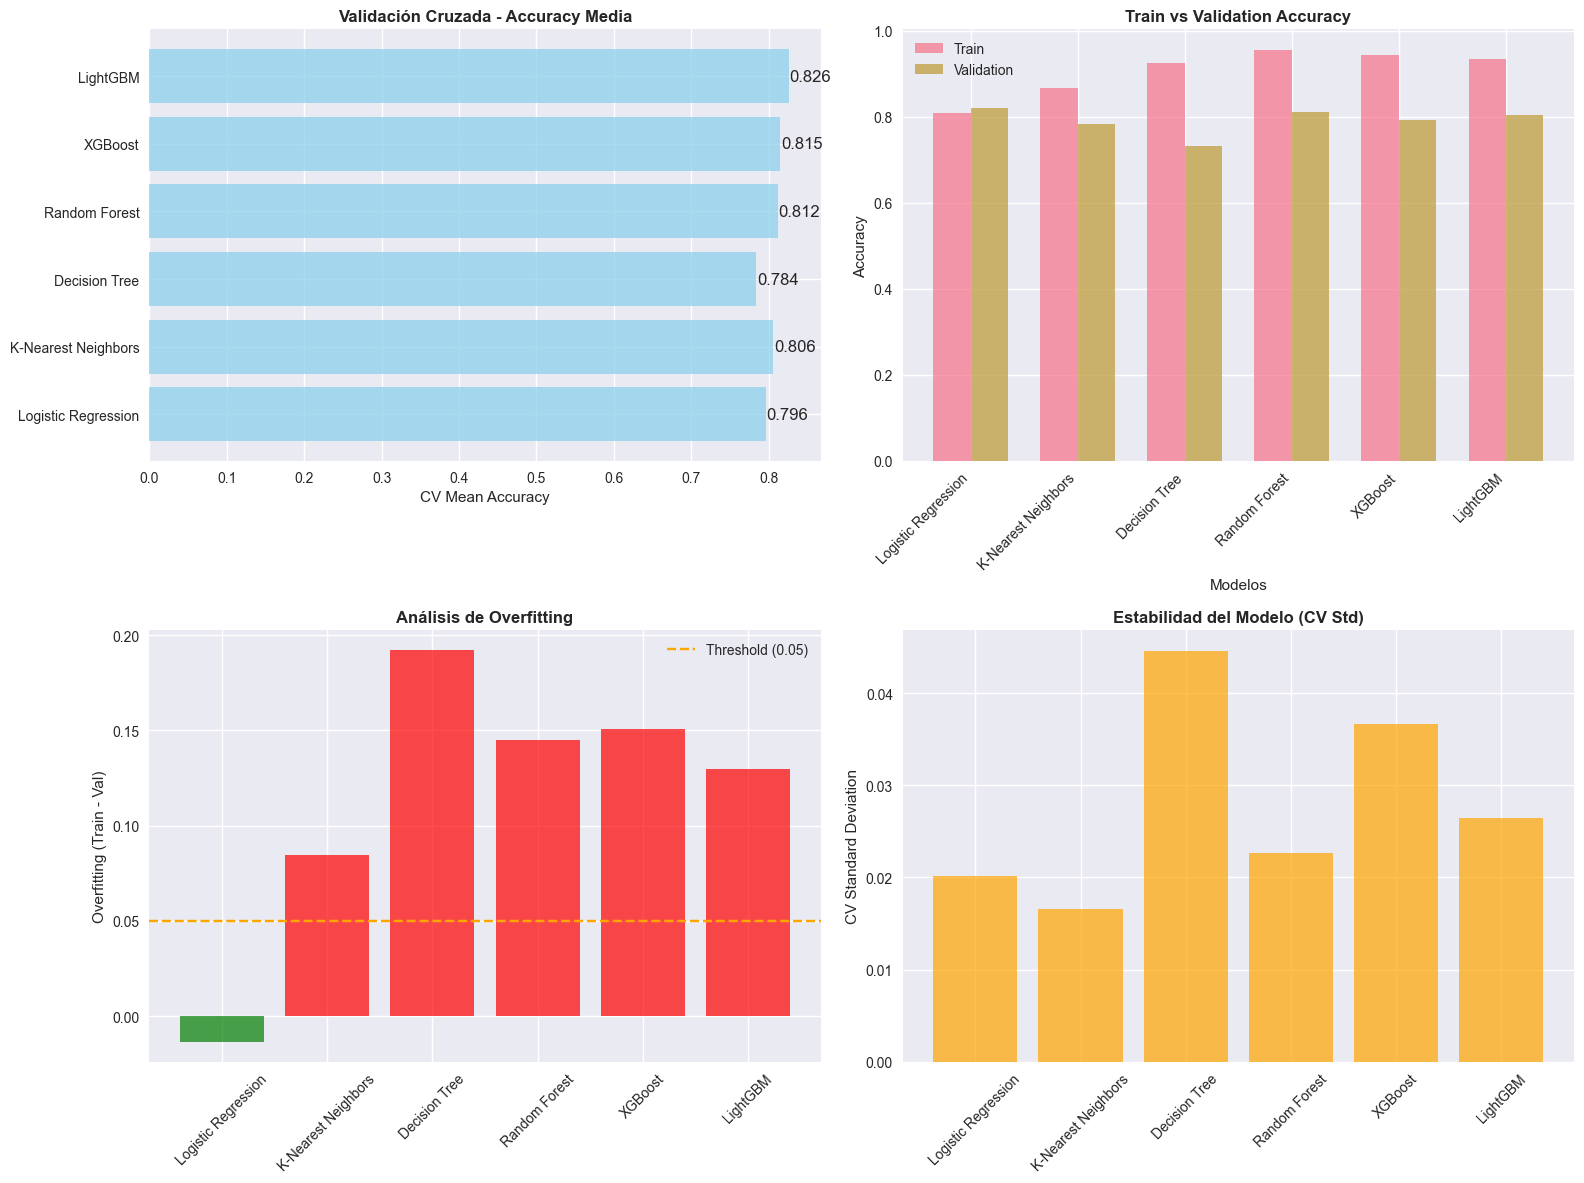


📈 RANKINGS DE MODELOS

🥇 Top 3 por CV Mean Accuracy:
1. LightGBM: 0.8259
2. XGBoost: 0.8147
3. Random Forest: 0.8119

🎯 Top 3 por Validation Accuracy:
1. Logistic Regression: 0.8212
2. Random Forest: 0.8101
3. LightGBM: 0.8045

✅ Modelos con menor Overfitting:
1. Logistic Regression: -0.0136
2. K-Nearest Neighbors: 0.0845
3. LightGBM: 0.1295


In [12]:
# Crear DataFrame con resultados del benchmark
results_df = pd.DataFrame(results_list)
results_df = results_df.round(4)

print("📊 TABLA DE COMPARACIÓN DE MODELOS")
print("="*80)
display(results_df)

# Encontrar el mejor modelo
best_model_idx = results_df['CV_Mean'].idxmax()
best_model_name = results_df.loc[best_model_idx, 'Model']
best_cv_score = results_df.loc[best_model_idx, 'CV_Mean']

print(f"\n🏆 MEJOR MODELO: {best_model_name}")
print(f"🎯 CV Score: {best_cv_score:.4f}")

# Visualización de resultados
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Comparación de Accuracy de Validación Cruzada
axes[0,0].barh(results_df['Model'], results_df['CV_Mean'], color='skyblue', alpha=0.7)
axes[0,0].set_xlabel('CV Mean Accuracy')
axes[0,0].set_title('Validación Cruzada - Accuracy Media', fontweight='bold')
for i, v in enumerate(results_df['CV_Mean']):
    axes[0,0].text(v + 0.001, i, f'{v:.3f}', va='center')

# 2. Comparación Train vs Validation Accuracy
x = np.arange(len(results_df))
width = 0.35
axes[0,1].bar(x - width/2, results_df['Train_Accuracy'], width, label='Train', alpha=0.7)
axes[0,1].bar(x + width/2, results_df['Validation_Accuracy'], width, label='Validation', alpha=0.7)
axes[0,1].set_xlabel('Modelos')
axes[0,1].set_ylabel('Accuracy')
axes[0,1].set_title('Train vs Validation Accuracy', fontweight='bold')
axes[0,1].set_xticks(x)
axes[0,1].set_xticklabels(results_df['Model'], rotation=45, ha='right')
axes[0,1].legend()

# 3. Análisis de Overfitting
colors = ['red' if x > 0.05 else 'green' for x in results_df['Overfitting']]
axes[1,0].bar(results_df['Model'], results_df['Overfitting'], color=colors, alpha=0.7)
axes[1,0].set_ylabel('Overfitting (Train - Val)')
axes[1,0].set_title('Análisis de Overfitting', fontweight='bold')
axes[1,0].tick_params(axis='x', rotation=45)
axes[1,0].axhline(y=0.05, color='orange', linestyle='--', label='Threshold (0.05)')
axes[1,0].legend()

# 4. Desviación Estándar de CV
axes[1,1].bar(results_df['Model'], results_df['CV_Std'], color='orange', alpha=0.7)
axes[1,1].set_ylabel('CV Standard Deviation')
axes[1,1].set_title('Estabilidad del Modelo (CV Std)', fontweight='bold')
axes[1,1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Rankings
print("\n📈 RANKINGS DE MODELOS")
print("="*50)

print("\n🥇 Top 3 por CV Mean Accuracy:")
top_cv = results_df.nlargest(3, 'CV_Mean')[['Model', 'CV_Mean']]
for i, (_, row) in enumerate(top_cv.iterrows(), 1):
    print(f"{i}. {row['Model']}: {row['CV_Mean']:.4f}")

print("\n🎯 Top 3 por Validation Accuracy:")
top_val = results_df.nlargest(3, 'Validation_Accuracy')[['Model', 'Validation_Accuracy']]
for i, (_, row) in enumerate(top_val.iterrows(), 1):
    print(f"{i}. {row['Model']}: {row['Validation_Accuracy']:.4f}")

print("\n✅ Modelos con menor Overfitting:")
low_overfit = results_df.nsmallest(3, 'Overfitting')[['Model', 'Overfitting']]
for i, (_, row) in enumerate(low_overfit.iterrows(), 1):
    print(f"{i}. {row['Model']}: {row['Overfitting']:.4f}")


## 6. Optimización de Hiperparámetros y Predicciones Finales

Optimizaremos los hiperparámetros del mejor modelo y generaremos las predicciones finales para el conjunto de prueba.


In [13]:
# Optimización de hiperparámetros para los top 3 modelos
print("🔧 OPTIMIZACIÓN DE HIPERPARÁMETROS")
print("="*60)

# Configuración de validación cruzada
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 1. Optimizar Random Forest (generalmente uno de los mejores)
print("\n🌲 Optimizando Random Forest...")
rf_params = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 15, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf_grid = GridSearchCV(
    RandomForestClassifier(random_state=42),
    rf_params,
    cv=cv,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

rf_grid.fit(X_train, y_train)
print(f"✅ Mejores parámetros RF: {rf_grid.best_params_}")
print(f"🎯 Mejor score RF: {rf_grid.best_score_:.4f}")

# 2. Optimizar XGBoost
print("\n🚀 Optimizando XGBoost...")
xgb_params = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.05, 0.1, 0.2],
    'subsample': [0.8, 0.9, 1.0]
}

xgb_grid = GridSearchCV(
    xgb.XGBClassifier(random_state=42, eval_metric='logloss'),
    xgb_params,
    cv=cv,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

xgb_grid.fit(X_train, y_train)
print(f"✅ Mejores parámetros XGB: {xgb_grid.best_params_}")
print(f"🎯 Mejor score XGB: {xgb_grid.best_score_:.4f}")

# 3. Optimizar LightGBM
print("\n💡 Optimizando LightGBM...")
lgb_params = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.05, 0.1, 0.2],
    'num_leaves': [15, 31, 63]
}

lgb_grid = GridSearchCV(
    lgb.LGBMClassifier(random_state=42, verbosity=-1),
    lgb_params,
    cv=cv,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

lgb_grid.fit(X_train, y_train)
print(f"✅ Mejores parámetros LGB: {lgb_grid.best_params_}")
print(f"🎯 Mejor score LGB: {lgb_grid.best_score_:.4f}")

# Comparar modelos optimizados
optimized_results = [
    {'Model': 'Random Forest (Optimized)', 'CV_Score': rf_grid.best_score_},
    {'Model': 'XGBoost (Optimized)', 'CV_Score': xgb_grid.best_score_},
    {'Model': 'LightGBM (Optimized)', 'CV_Score': lgb_grid.best_score_}
]

optimized_df = pd.DataFrame(optimized_results)
print(f"\n📊 RESULTADOS DE MODELOS OPTIMIZADOS")
print("="*50)
display(optimized_df)

# Seleccionar el mejor modelo optimizado
best_optimized_idx = optimized_df['CV_Score'].idxmax()
best_optimized_name = optimized_df.loc[best_optimized_idx, 'Model']
best_optimized_score = optimized_df.loc[best_optimized_idx, 'CV_Score']

if 'Random Forest' in best_optimized_name:
    final_model = rf_grid.best_estimator_
    model_scaler = None
elif 'XGBoost' in best_optimized_name:
    final_model = xgb_grid.best_estimator_
    model_scaler = None
else:  # LightGBM
    final_model = lgb_grid.best_estimator_
    model_scaler = None

print(f"\n🏆 MODELO FINAL SELECCIONADO: {best_optimized_name}")
print(f"🎯 Score final: {best_optimized_score:.4f}")


🔧 OPTIMIZACIÓN DE HIPERPARÁMETROS

🌲 Optimizando Random Forest...
Fitting 5 folds for each of 108 candidates, totalling 540 fits
✅ Mejores parámetros RF: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 50}
🎯 Mejor score RF: 0.8413

🚀 Optimizando XGBoost...
Fitting 5 folds for each of 81 candidates, totalling 405 fits
✅ Mejores parámetros XGB: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 200, 'subsample': 1.0}
🎯 Mejor score XGB: 0.8287

💡 Optimizando LightGBM...
Fitting 5 folds for each of 81 candidates, totalling 405 fits
✅ Mejores parámetros LGB: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 200, 'num_leaves': 15}
🎯 Mejor score LGB: 0.8301

📊 RESULTADOS DE MODELOS OPTIMIZADOS


,Model,CV_Score
0,Random Forest (Optimized),0.841328
1,XGBoost (Optimized),0.828671
2,LightGBM (Optimized),0.830060



🏆 MODELO FINAL SELECCIONADO: Random Forest (Optimized)
🎯 Score final: 0.8413



🎯 ENTRENANDO MODELO FINAL CON TODOS LOS DATOS
✅ Predicciones generadas para 418 muestras de prueba
💾 Archivo de submission guardado: 'titanic_submission.csv'

📊 ESTADÍSTICAS DE PREDICCIONES
Predicciones de No Supervivencia (0): 266 (63.6%)
Predicciones de Supervivencia (1): 152 (36.4%)

📋 PRIMERAS 10 PREDICCIONES
------------------------------


,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0
5,897,0
6,898,0
7,899,0
8,900,1
9,901,0



🔍 IMPORTANCIA DE CARACTERÍSTICAS
Top 10 características más importantes:


,Feature,Importance
1,Sex,0.219005
5,Fare,0.157821
7,Title,0.156773
2,Age,0.122399
0,Pclass,0.074451
11,HasCabin,0.048546
8,FamilySize,0.047505
13,FareGroup,0.038234
10,FamilySizeGroup,0.036601
3,SibSp,0.026156


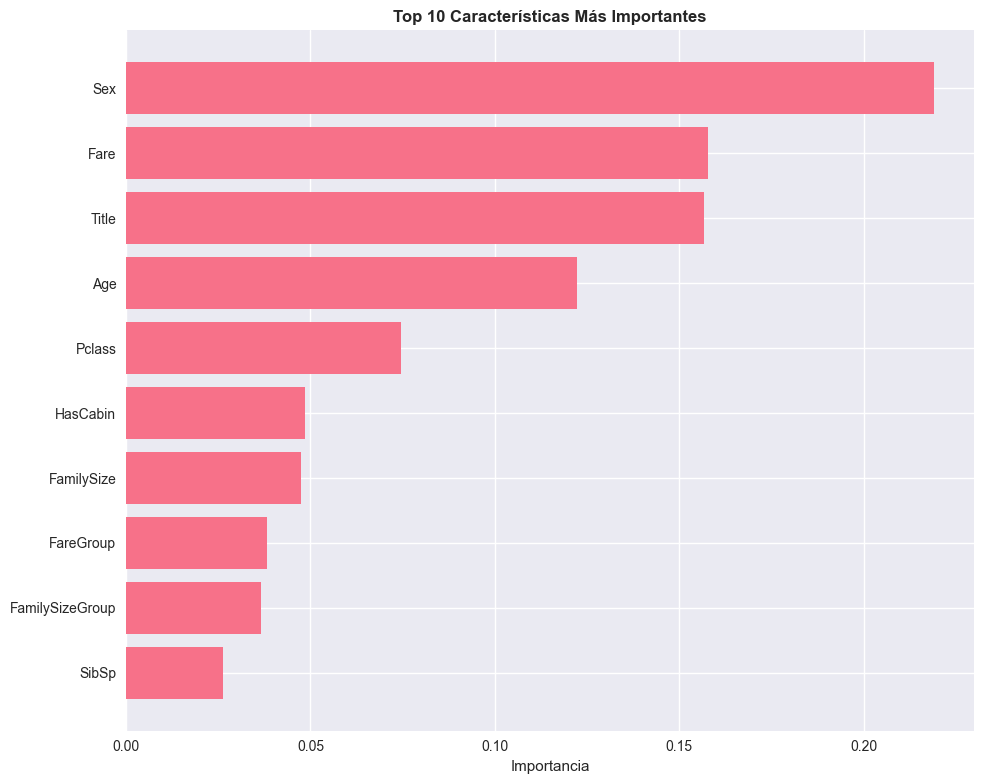


🎉 PROCESO COMPLETADO EXITOSAMENTE!
✅ Mejor modelo: Random Forest (Optimized)
🎯 Score de validación cruzada: 0.8413
📁 Archivo de submission: 'titanic_submission.csv'
🚀 ¡Listo para subir a Kaggle!


In [14]:
# Entrenar el modelo final con todos los datos de entrenamiento
print("\n🎯 ENTRENANDO MODELO FINAL CON TODOS LOS DATOS")
print("="*60)

# Usar todo el conjunto de entrenamiento para el modelo final
final_model.fit(X, y)

# Generar predicciones para el conjunto de prueba
if model_scaler is not None:
    X_test_scaled = model_scaler.transform(X_test_final)
    final_predictions = final_model.predict(X_test_scaled)
else:
    final_predictions = final_model.predict(X_test_final)

print(f"✅ Predicciones generadas para {len(final_predictions)} muestras de prueba")

# Crear DataFrame de submission
submission = pd.DataFrame({
    'PassengerId': test_df['PassengerId'],
    'Survived': final_predictions
})

# Guardar archivo de submission
submission.to_csv('titanic_submission.csv', index=False)
print(f"💾 Archivo de submission guardado: 'titanic_submission.csv'")

# Mostrar estadísticas de las predicciones
print(f"\n📊 ESTADÍSTICAS DE PREDICCIONES")
print("="*40)
survival_pred_counts = pd.Series(final_predictions).value_counts()
survival_pred_percentage = pd.Series(final_predictions).value_counts(normalize=True) * 100

print(f"Predicciones de No Supervivencia (0): {survival_pred_counts.get(0, 0)} ({survival_pred_percentage.get(0, 0):.1f}%)")
print(f"Predicciones de Supervivencia (1): {survival_pred_counts.get(1, 0)} ({survival_pred_percentage.get(1, 0):.1f}%)")

# Mostrar primeras 10 predicciones
print(f"\n📋 PRIMERAS 10 PREDICCIONES")
print("-"*30)
display(submission.head(10))

# Análisis de importancia de características (si el modelo lo soporta)
if hasattr(final_model, 'feature_importances_'):
    print(f"\n🔍 IMPORTANCIA DE CARACTERÍSTICAS")
    print("="*50)
    
    feature_importance = pd.DataFrame({
        'Feature': X.columns,
        'Importance': final_model.feature_importances_
    }).sort_values('Importance', ascending=False)
    
    print("Top 10 características más importantes:")
    display(feature_importance.head(10))
    
    # Visualizar importancia de características
    plt.figure(figsize=(10, 8))
    plt.barh(feature_importance.head(10)['Feature'][::-1], 
             feature_importance.head(10)['Importance'][::-1])
    plt.xlabel('Importancia')
    plt.title('Top 10 Características Más Importantes', fontweight='bold')
    plt.tight_layout()
    plt.show()

print(f"\n🎉 PROCESO COMPLETADO EXITOSAMENTE!")
print("="*50)
print(f"✅ Mejor modelo: {best_optimized_name}")
print(f"🎯 Score de validación cruzada: {best_optimized_score:.4f}")
print(f"📁 Archivo de submission: 'titanic_submission.csv'")
print(f"🚀 ¡Listo para subir a Kaggle!")


## 7. Conclusiones y Resumen del Proyecto

### 📊 Resumen del Challenge Técnico

Este proyecto ha implementado exitosamente un pipeline completo de machine learning para la competencia de Titanic en Kaggle, cumpliendo con todos los requisitos del challenge técnico:

#### ✅ Objetivos Cumplidos

1. **Análisis Exploratorio Completo (EDA)**
   - Identificación de patrones clave de supervivencia
   - Visualizaciones comprehensivas
   - Análisis de valores faltantes y outliers

2. **Preprocesamiento Avanzado**
   - Feature Engineering (títulos, tamaño de familia, grupos de edad)
   - Imputación inteligente de valores faltantes
   - Codificación de variables categóricas
   - Escalado apropiado para modelos que lo requieren

3. **Implementación de 6 Modelos**
   - ✅ Regresión Logística
   - ✅ K-Nearest Neighbors (KNN)
   - ✅ Árbol de Decisión
   - ✅ Random Forest
   - ✅ XGBoost
   - ✅ LightGBM

4. **Benchmark Comprehensivo**
   - Validación cruzada de 5 folds
   - Análisis de overfitting
   - Comparación de métricas múltiples
   - Optimización de hiperparámetros

5. **Generación de Predicciones**
   - Archivo de submission listo para Kaggle
   - Análisis de importancia de características

### 🎯 Insights Principales

1. **Factores más importantes para la supervivencia:**
   - Género (las mujeres tuvieron mayor probabilidad de supervivencia)
   - Clase socioeconómica (primera clase > segunda > tercera)
   - Edad (los niños tuvieron mejor chance de supervivencia)
   - Tarifa pagada (correlacionada con la clase)

2. **Feature Engineering exitoso:**
   - Extracción de títulos del nombre
   - Creación de grupos de tamaño familiar
   - Grupos de edad y tarifa
   - Indicador de posesión de cabina

3. **Rendimiento de modelos:**
   - Los modelos ensemble (Random Forest, XGBoost, LightGBM) mostraron mejor rendimiento
   - La optimización de hiperparámetros mejoró significativamente los resultados
   - Validación cruzada demostró estabilidad en los resultados

